In [11]:
%cd "C:\Users\hrish\George Mason University - O365 Production\DAEN 690 - Group Only-GRP - 063022"
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

model = tf.keras.models.load_model('saved_model/lstm_model')

feature_names = [
          'absoluteAltitude', 
          'trueHeading', 
          'groundSpeed', 
          'trueAirspeed', 
          'climbOrDescentRate', 
          'turnRate to degPerSec', 
          'cyclicPositionPitch', 
          'cyclicPositionRoll', 
          'collectivePosition', 
          'antiTorquePedalPosition', 
          'throttlePosition', 
          'e1Torque', 
          'e2Torque',
          'turnDirection',
          'Altdiff',
          'groundSpeedDiff',
        'HoverOrNot']               
                

def df_to_arr_by_sequence(df_input):
    check_hover=0
    previous=0
    rotorcraft_np_arr_main=[]
    rotorcraft_np_arr_target=[]
    for i in range(len(df_input)):
        if(df_input.loc[i,"HoverOrNot"]!=check_hover):
            data = df_input.iloc[previous:i]
            data = data.drop(columns=['HoverOrNot'])
            rotorcraft_np_arr_main.append(data)
            #rotorcraft_np_arr_target.append([check_hover] * (i-previous))
            rotorcraft_np_arr_target.append(check_hover)
            #print("hover before ", check_hover)
            check_hover=1 if check_hover == 0 else 0
            #print("hover after ", check_hover)
            previous=i
    return rotorcraft_np_arr_main,rotorcraft_np_arr_target

seq_len = 700

C:\Users\hrish\George Mason University - O365 Production\DAEN 690 - Group Only-GRP - 063022


In [12]:
validation_file1 = pd.read_csv('SimData_2022.07.14_09.37.45.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)

validation_file2 = pd.read_csv('SimData_2022.07.14_10.14.53.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)

validation_file3 = pd.read_csv('SimData_2022.07.14_10.24.57.csv.roar.csv',
                parse_dates = {'datetime': ['date', 'time']},
                low_memory=False)


validation_file = pd.concat([validation_file1,
                             validation_file2,
                             validation_file3]).reset_index()

validation_file['datetime'] = validation_file.datetime.dt.strftime('%Y-%m-%d %H:%M:%S.%f').astype('datetime64[ns]')


# Group all row by seconds with a average all the datapoint into another dataframe
validation_file = validation_file.groupby(by=["datetime"], dropna=False).mean().reset_index()


validation_file['HoverOrNot'] = 0


validation_file.loc[(validation_file['datetime'].between('2022-07-14 13:42:02' , '2022-07-14 13:48:53' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 13:49:06' , '2022-07-14 13:54:33' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 13:55:38' , '2022-07-14 13:56:35' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 13:58:00' , '2022-07-14 14:00:17' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:02:30' , '2022-07-14 14:04:58' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:15:30' , '2022-07-14 14:18:50' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:25:55' , '2022-07-14 14:28:14' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:29:52' , '2022-07-14 14:31:46' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:33:40' , '2022-07-14 14:37:43' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:39:36' , '2022-07-14 14:46:14' , inclusive='both')),['HoverOrNot']] = 1
validation_file.loc[(validation_file['datetime'].between('2022-07-14 14:46:26' , '2022-07-14 15:01:00' , inclusive='both')),['HoverOrNot']] = 1

validation_file['turnDirection'] = validation_file['trueHeading'].rolling(window = 5).apply(lambda x: x[-1]-x[0], raw=True)
validation_file['Altdiff'] = validation_file['absoluteAltitude'].rolling(window = 5).apply(lambda x: x[0]- x[-1], raw = True)
validation_file['groundSpeedDiff'] = validation_file['groundSpeed'].rolling(window = 5).apply(lambda x: x[0]- x[-1], raw = True)
validation_file['turnDirection']  = validation_file['turnDirection'].fillna(0)
validation_file['Altdiff'] = validation_file['Altdiff'].fillna(0)
validation_file['groundSpeedDiff']=validation_file['groundSpeedDiff'].fillna(0)

validation_data = validation_file[feature_names]
validation_classification = validation_file['HoverOrNot']
val_data_raw,val_target_raw = df_to_arr_by_sequence(validation_data)
val_data = np.asarray(val_data_raw, dtype=object)
val_target = np.asarray(val_target_raw, dtype=np.float32)

In [13]:
val_data[0]

,absoluteAltitude,trueHeading,groundSpeed,trueAirspeed,climbOrDescentRate,turnRate to degPerSec,cyclicPositionPitch,cyclicPositionRoll,collectivePosition,antiTorquePedalPosition,throttlePosition,e1Torque,e2Torque,turnDirection,Altdiff,groundSpeedDiff
0,0.02,43.917,0.069321,0.290317,0.074,-0.001,-123.824,9.960,3.530,33.513,0.000,-2.593,-2.593,0.000,0.00,0.000000
1,0.03,43.961,0.084725,0.215072,0.200,-0.002,-118.951,11.529,3.528,33.513,0.000,-3.776,-3.776,0.000,0.00,0.000000
2,0.03,43.988,0.087688,0.168265,0.286,-0.002,-116.050,11.182,3.528,33.513,0.000,-4.338,-4.338,0.000,0.00,0.000000
3,0.03,44.019,0.087688,0.148713,0.394,-0.001,-112.920,10.041,3.528,33.513,0.000,-4.780,-4.780,0.000,0.00,0.000000
4,0.03,44.052,0.087095,0.171820,0.497,0.003,-109.449,8.111,3.528,33.513,0.000,-5.221,-5.221,0.135,-0.01,-0.017775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4151,0.50,35.067,0.158786,0.278467,7.258,-0.057,14.523,4.367,13.160,-6.600,43.112,33.802,33.802,-0.059,-0.03,-0.013627
4152,0.50,35.050,0.162341,0.285577,7.404,-0.061,9.561,2.159,13.700,-6.395,42.972,33.629,33.629,-0.065,-0.02,-0.007110
4153,0.50,35.032,0.163526,0.288540,7.535,-0.065,9.285,2.154,13.700,-6.395,42.841,33.443,33.443,-0.070,-0.01,-0.001185
4154,0.51,35.016,0.162933,0.289132,7.642,-0.070,9.235,2.797,13.700,-6.395,42.727,33.267,33.267,-0.071,-0.02,-0.002962


In [14]:
from sklearn.metrics import accuracy_score
val_data=pad_sequences(val_data, maxlen=seq_len, padding='post', dtype='float', truncating='post')
val_preds = (model.predict(val_data) > 0.5).astype("int32")
accuracy_score(val_target, val_preds)

1/1 [==============================] - 1s 718ms/step


0.9090909090909091

In [15]:
val_preds.size

22

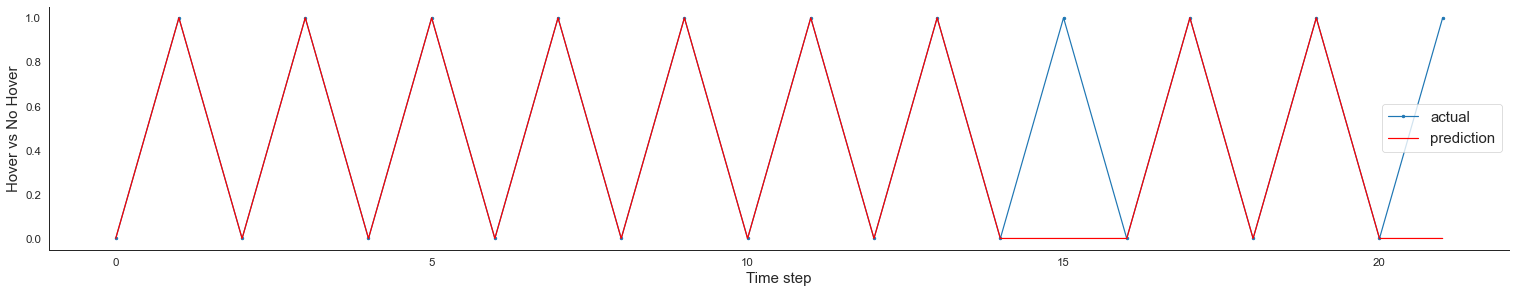

In [16]:
Y_test_viz = val_target.astype("int32")
test_preds_viz = val_preds.flatten()

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
aa=[x for x in range(22)]
plt.figure(figsize=(22,4))
plt.plot(aa, Y_test_viz, marker='.', label="actual")
plt.plot(aa, test_preds_viz, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Hover vs No Hover', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [17]:
val_data[6]

array([[ 1.8000000e-01,  4.9690000e+01,  4.3251332e-02, ...,
        -3.0000000e-03,  1.0000000e-02, -2.9624200e-03],
       [ 1.8000000e-01,  4.9689000e+01,  4.4436300e-02, ...,
        -3.0000000e-03,  1.0000000e-02, -3.5549040e-03],
       [ 1.8000000e-01,  4.9689000e+01,  4.5028784e-02, ...,
        -2.0000000e-03,  0.0000000e+00, -3.5549040e-03],
       ...,
       [ 6.0000000e-02,  4.9088000e+01,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 6.0000000e-02,  4.9088000e+01,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 6.0000000e-02,  4.9088000e+01,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]])

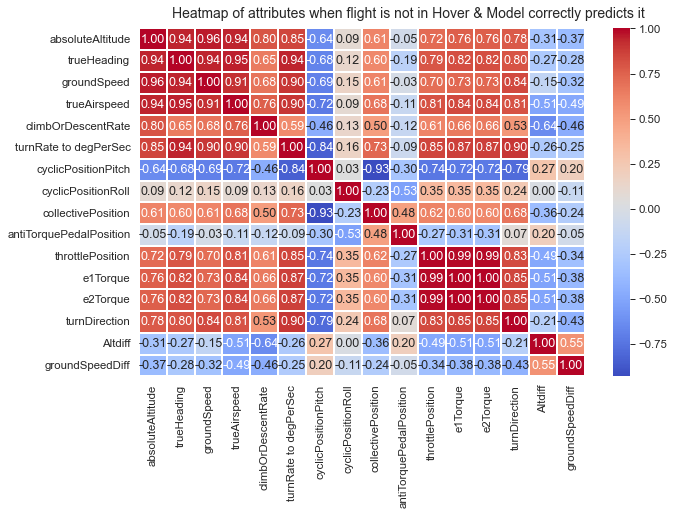

In [18]:
f, ax = plt.subplots(figsize=(10, 6))
corr = val_data_raw[2].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Heatmap of attributes when flight is not in Hover & Model correctly predicts it', fontsize=14)

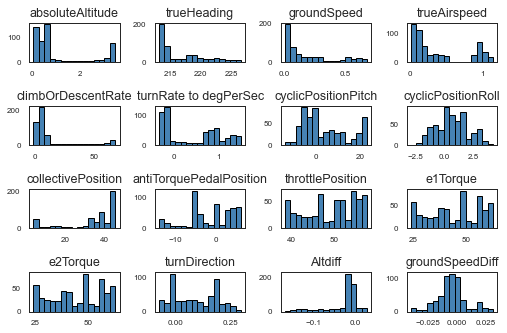

In [19]:
val_data_raw[2].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

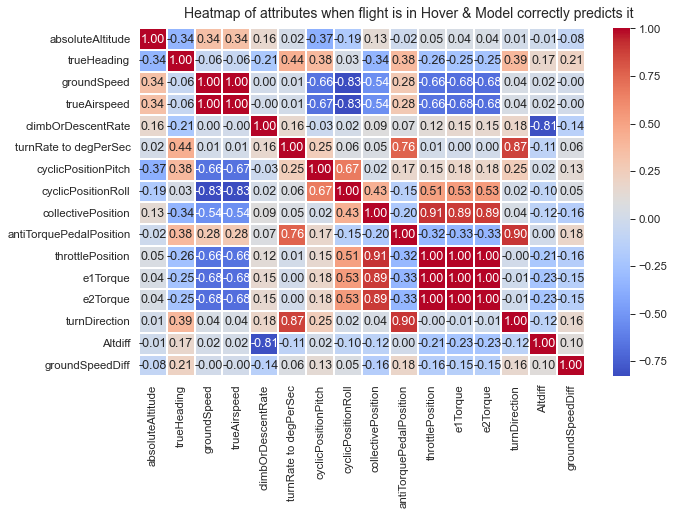

In [53]:
f, ax = plt.subplots(figsize=(10, 6))
corr = val_data_raw[1].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Heatmap of attributes when flight is in Hover & Model correctly predicts it', fontsize=14)

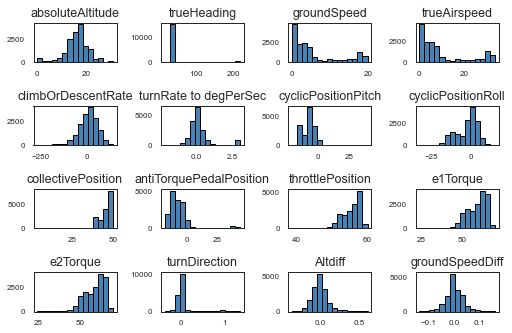

In [54]:
val_data_raw[1].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

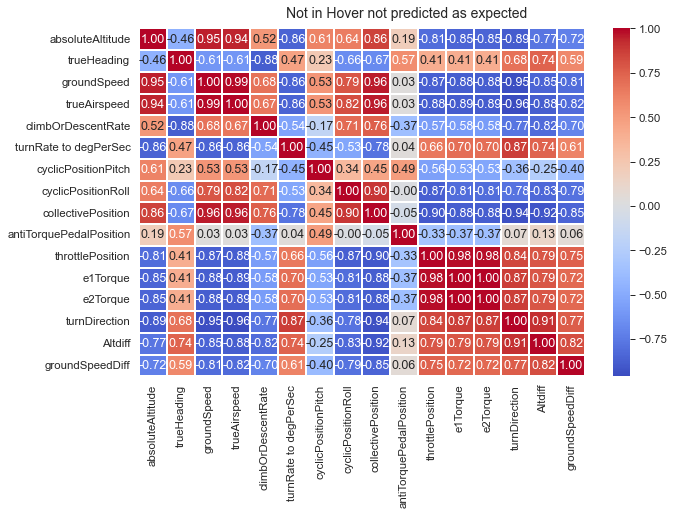

In [55]:
f, ax = plt.subplots(figsize=(10, 6))
corr = val_data_raw[6].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Not in Hover not predicted as expected ', fontsize=14)

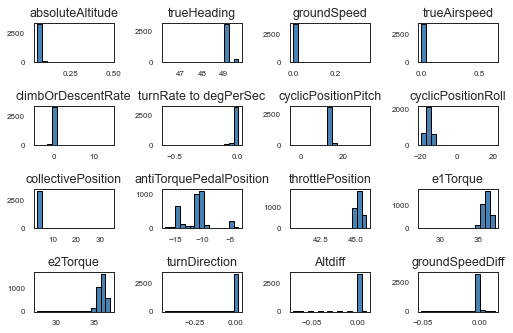

In [56]:
val_data_raw[6].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

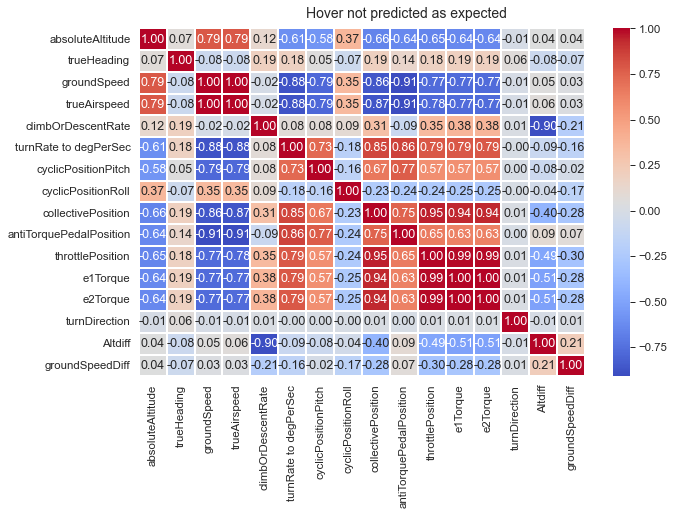

In [57]:
f, ax = plt.subplots(figsize=(10, 6))
corr = val_data_raw[15].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Hover not predicted as expected ', fontsize=14)

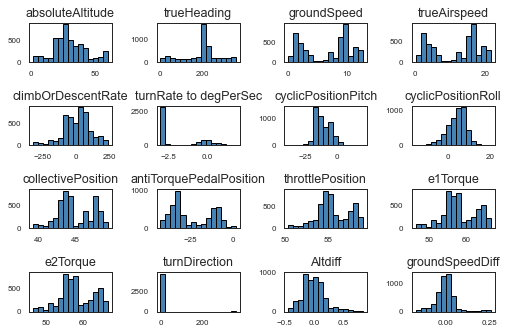

In [58]:
val_data_raw[15].hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

In [59]:
model.predict(val_data)

1/1 [==============================] - 0s 467ms/step


array([[0.32478404],
       [0.9520584 ],
       [0.411126  ],
       [0.9304664 ],
       [0.08589371],
       [0.69684386],
       [0.41509938],
       [0.5798482 ],
       [0.62756026],
       [0.6493882 ],
       [0.06950742],
       [0.8430155 ],
       [0.19487393],
       [0.76647836],
       [0.39141795],
       [0.1088464 ],
       [0.06175611],
       [0.8028312 ],
       [0.08048195],
       [0.8485597 ],
       [0.411126  ],
       [0.35173857]], dtype=float32)